### Crop AVISO dataset to Gulf Stream Eddies

Data file from AVISO during Hackweek: 'Eddy_trajectory_nrt_3.2exp_cyclonic_20180101_20240723.nc'

Updated files downloaded 02/03/2025 (allsat): 
- 'Eddy_trajectory_nrt_3.2exp_cyclonic_20180101_20241111.nc'
- 'Eddy_trajectory_nrt_3.2exp_anticyclonic_20180101_20241111.nc'


Lexi Jones-Kellett

Date created: 08/06/24

Last edited: 02/04/25

In [1]:
import math, pylab, csv
import xarray as xr
import netCDF4
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
from itertools import groupby
from matplotlib.path import Path
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.dates as mdates

In [2]:
fontsize = 18

plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title

## Hackweek Pipeline

In [9]:
ds = xr.open_dataset('../Eddy_trajectory_nrt_3.2exp_cyclonic_20180101_20240723.nc', engine="netcdf4")
ds

<xarray.Dataset>
Dimensions:                        (obs: 8408689, NbSample: 20)
Dimensions without coordinates: obs, NbSample
Data variables: (12/27)
    amplitude                      (obs) float32 ...
    effective_area                 (obs) float32 ...
    effective_contour_height       (obs) float32 ...
    effective_contour_latitude     (obs, NbSample) float32 ...
    effective_contour_longitude    (obs, NbSample) float32 ...
    effective_contour_shape_error  (obs) float32 ...
    ...                             ...
    speed_contour_longitude        (obs, NbSample) float32 ...
    speed_contour_shape_error      (obs) float32 ...
    speed_radius                   (obs) float32 ...
    time                           (obs) datetime64[ns] ...
    track                          (obs) uint32 ...
    uavg_profile                   (obs, NbSample) float32 ...
Attributes: (12/19)
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    creator_email:             aviso@altimetry.fr
    creator_url:               https://www.aviso.altimetry.fr
    date_created:              2024-08-06T09:38:06Z
    framework_used:            https://github.com/AntSimi/py-eddy-tracker
    ...                        ...
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    summary:                   This dataset contains eddy atlas from all-sate...
    time_coverage_duration:    P2396D
    time_coverage_end:         2024-07-23T00:00:00Z
    time_coverage_start:       2018-01-01T00:00:00Z
    title:                     Mesoscale Cyclonic Eddies in Altimeter Observa...

In [11]:
lat_min,lat_max = 34.5,37
lon_min,lon_max = -73+360,-68+360

subset_inds = np.where(((ds.latitude > lat_min) & (ds.latitude < lat_max)) & 
                       ((ds.longitude > lon_min) & (ds.longitude < lon_max)) & 
                       ((ds.time) >= np.datetime64('2024-04-01')))[0]
print(len(subset_inds))

149


In [12]:
lat,lon,time,track = [],[],[],[]
for i in subset_inds: 
    this_track_id = int(ds.track[i].values)
    if ds.longitude[i] > 360:
        lon.append(float((ds.longitude[i] - 360).values))
    else:
        lon.append(float(ds.longitude[i].values))
    lat.append(float(ds.latitude[i].values))
    time.append(np.datetime64(ds.time[i].values))
    track.append(this_track_id)

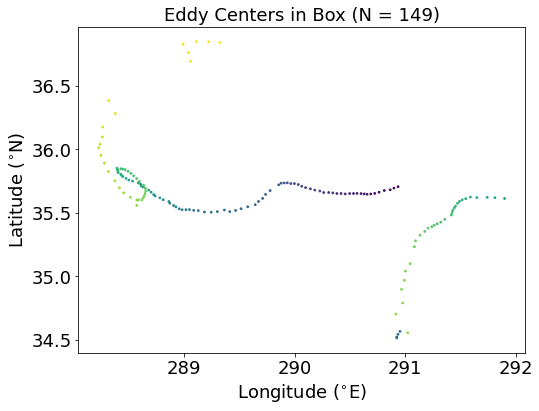

In [13]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

ax.scatter(lon,lat,s=3,c=time)
scat = ax.set_title('Eddy Centers in Box (N = %s)'%(len(track)))
ax.set_xlabel('Longitude ($^{\circ}$E)');
ax.set_ylabel('Latitude ($^{\circ}$N)');

In [14]:
np.unique(track)

array([154367, 174440, 184611])

Refine down to the one track ID = 174440

In [15]:
subset_inds = np.where((ds.track==174440))[0]

In [16]:
lat,lon,time,track = [],[],[],[]
for i in subset_inds: 
    this_track_id = int(ds.track[i].values)
    if ds.longitude[i] > 360:
        lon.append(float((ds.longitude[i] - 360).values))
    else:
        lon.append(float(ds.longitude[i].values))
    lat.append(float(ds.latitude[i].values))
    time.append(np.datetime64(ds.time[i].values))
    track.append(this_track_id)

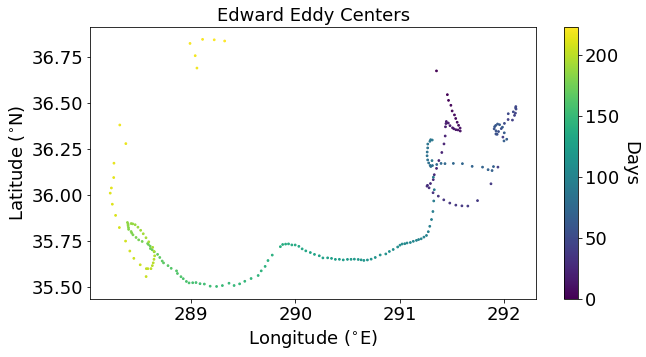

In [19]:
fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.scatter(lon,lat,s=3,c=time)
scat = ax.set_title('Edward Eddy Centers')
ax.set_xlabel('Longitude ($^{\circ}$E)');
ax.set_ylabel('Latitude ($^{\circ}$N)');

# Create a colorbar
norm = Normalize(vmin=0, vmax=len(time))
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Dummy array for the colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Days', rotation=270,labelpad=20)

# Format colorbar ticks as dates
#cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

In [20]:
def get_eddy_by_ID_date(ds,track_id,eddy_date):
    """
    ds: netCDF AVISO format
    track_id: id of eddy to extract
    eddy_date: date in format 'YYYY-MM-DD'

    Returns contour lons, contour lats, center lon, center lat
    """
    try:
        ind = np.where((ds.track == track_id) & (ds.time == np.datetime64(eddy_date)))[0][0]
        contour_lons = np.array(ds.effective_contour_longitude[ind])
        contour_lats = np.array(ds.effective_contour_latitude[ind])
    except:
        print('No eddy data available with that request ... :(')        
    
    return contour_lons,contour_lats,ds.longitude[ind],ds.latitude[ind]

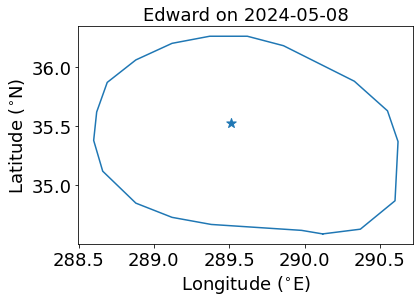

In [21]:
date_to_plot = '2024-05-08'

############################
contour_lons,contour_lats,center_lon,center_lat = get_eddy_by_ID_date(ds,174440,date_to_plot)

# Plot
plt.plot(contour_lons,contour_lats)
plt.scatter(center_lon,center_lat,marker='*',s=100)

# Labels
plt.title('Edward on %s'%(date_to_plot))
plt.xlabel('Longitude ($^{\circ}$E)');
plt.ylabel('Latitude ($^{\circ}$N)');

Test plotting first 10 days of the contour

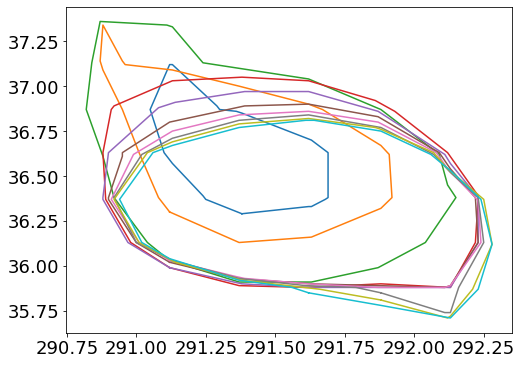

In [22]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

for t in time[0:10]:
    ind = np.where((ds.track == 174440) & (ds.time == np.datetime64(t)))[0][0]
    contour_lons = np.array(ds.effective_contour_longitude[ind])
    contour_lats = np.array(ds.effective_contour_latitude[ind])
    ax.plot(contour_lons,contour_lats)


In [23]:
print(len(time))
print(min(time))
print(max(time))

223
2023-12-14T00:00:00.000000000
2024-07-23T00:00:00.000000000


How old is Edward on May 8th, 2024?

In [24]:
(np.datetime64('2024-05-08') - time[0]).astype('timedelta64[D]')/ np.timedelta64(1, 'D')

146.0

### Save Edward Subset

In [ ]:
ds_Edward = ds.isel(obs=subset_inds)
ds_Edward.to_netcdf('Edward_Eddy_trajectory_nrt_3.2exp_cyclonic_20180101_20240723.nc')

Test opening Edward subset of the data

In [ ]:
ds = xr.open_dataset('Edward_Eddy_trajectory_nrt_3.2exp_cyclonic_20180101_20240723.nc')
ds

Test checking if a float is in or out of the eddy

In [25]:
def in_eddy(ds,float_lat,float_lon,float_time):
    """
    float_lat: degrees north
    float_lon: degrees east
    float_time: should be in format 'YYYY-MM-DD'
    """

    def all_equal(iterable):
        g = groupby(iterable)
        return next(g, True) and not next(g, False)

    in_eddy_flag = False 

    float_time = np.datetime64(float_time)
    if float_time in ds.time: # some dates not in dateset        
        for i in np.where(ds.time == float_time)[0]: # usually will only be 1 eddy, but sometimes there are 2 after a split
            contour_lons = np.array(ds.effective_contour_longitude[i]) # eddy lons
            contour_lats = np.array(ds.effective_contour_latitude[i]) # eddy lats
            
            if all_equal(contour_lons): # eddy break
                pass
            else:
                poly = Path([(contour_lats[j],contour_lons[j]) for j in np.arange(0,len(contour_lats))]) # set up the polygon
                if poly.contains_points([(float_lat,float_lon)]): #find if point is inside the polygon
                    in_eddy_flag = True 

    return in_eddy_flag

In [ ]:
in_eddy(ds,35,289.5,'2024-05-09')

# BGC-Argo Co-locate

Marin subsetted the BGC-Argo floats located in the Gulf Stream region 

 --------60--------
 
-10  Gulf Stream -76

 --------30--------

In [3]:
argo_df = pd.read_csv('../BGC_floats_Cornec_20250125.csv')
argo_df

,WMO,WMO_CYCLE,DATE,LON,LAT,CHLA,BBP,DOXY,NO3,PH,PAR
0,1902304,1902304_150,2024-01-09,-16.197,54.261,YES,YES,YES,YES,YES,NO
1,1902304,1902304_151,2024-01-19,-16.829,54.248,YES,YES,YES,YES,YES,NO
2,1902304,1902304_152,2024-01-30,-17.855,54.507,YES,YES,YES,YES,YES,NO
3,1902304,1902304_154,2024-02-20,-19.162,54.789,YES,YES,YES,YES,YES,NO
4,1902304,1902304_155,2024-03-01,-19.243,54.658,YES,YES,YES,YES,YES,NO
...,...,...,...,...,...,...,...,...,...,...,...
1871,4902688,4902688_056,2024-12-29,-52.153,59.486,YES,YES,YES,NO,NO,YES
1872,4902688,4902688_057,2025-01-04,-52.065,59.398,YES,YES,YES,NO,NO,YES
1873,4902688,4902688_058,2025-01-10,-52.066,59.233,YES,YES,YES,NO,NO,YES
1874,4902688,4902688_059,2025-01-16,-52.164,59.497,YES,YES,YES,NO,NO,YES


In [4]:
print(min(argo_df.DATE))
print(min(argo_df.LON))
print(max(argo_df.LON))
print(min(argo_df.LAT))
print(max(argo_df.LAT))

2024-01-01
-76.07
-10.004
30.107
59.989


Subset eddy datasets to same region / temporal cutoff; skip to next section if already done

In [5]:
anti_ds = xr.open_dataset('../Eddy_trajectory_nrt_3.2exp_anticyclonic_20180101_20241111.nc', engine="netcdf4")
cyc_ds = xr.open_dataset('../Eddy_trajectory_nrt_3.2exp_cyclonic_20180101_20241111.nc', engine="netcdf4")
cyc_ds

<xarray.Dataset>
Dimensions:                        (obs: 8804277, NbSample: 20)
Dimensions without coordinates: obs, NbSample
Data variables: (12/27)
    amplitude                      (obs) float32 ...
    effective_area                 (obs) float32 ...
    effective_contour_height       (obs) float32 ...
    effective_contour_latitude     (obs, NbSample) float32 ...
    effective_contour_longitude    (obs, NbSample) float32 ...
    effective_contour_shape_error  (obs) float32 ...
    ...                             ...
    speed_contour_longitude        (obs, NbSample) float32 ...
    speed_contour_shape_error      (obs) float32 ...
    speed_radius                   (obs) float32 ...
    time                           (obs) datetime64[ns] ...
    track                          (obs) uint32 ...
    uavg_profile                   (obs, NbSample) float32 ...
Attributes: (12/19)
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    creator_email:             aviso@altimetry.fr
    creator_url:               https://www.aviso.altimetry.fr
    date_created:              2025-02-03T08:39:10Z
    framework_used:            https://github.com/AntSimi/py-eddy-tracker
    ...                        ...
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    summary:                   This dataset contains eddy atlas from all-sate...
    time_coverage_duration:    P2507D
    time_coverage_end:         2024-11-11T00:00:00Z
    time_coverage_start:       2018-01-01T00:00:00Z
    title:                     Mesoscale Cyclonic Eddies in Altimeter Observa...

In [6]:
def crop_ds(ds):
    lat_min,lat_max = min(argo_df.LAT),max(argo_df.LAT)
    lon_min,lon_max = min(argo_df.LON)+360,max(argo_df.LON)+360

    subset_inds = np.where(((ds.latitude >= lat_min) & (ds.latitude <= lat_max)) & 
                            ((ds.longitude >= lon_min) & (ds.longitude <= lon_max)) & 
                            ((ds.time) >= np.datetime64('2024-01-01')))[0]
    
    return ds.isel(obs=subset_inds)

In [7]:
anti_ds = crop_ds(anti_ds)
anti_ds

<xarray.Dataset>
Dimensions:                        (obs: 68573, NbSample: 20)
Dimensions without coordinates: obs, NbSample
Data variables: (12/27)
    amplitude                      (obs) float32 ...
    effective_area                 (obs) float32 ...
    effective_contour_height       (obs) float32 ...
    effective_contour_latitude     (obs, NbSample) float32 ...
    effective_contour_longitude    (obs, NbSample) float32 ...
    effective_contour_shape_error  (obs) float32 ...
    ...                             ...
    speed_contour_longitude        (obs, NbSample) float32 ...
    speed_contour_shape_error      (obs) float32 ...
    speed_radius                   (obs) float32 ...
    time                           (obs) datetime64[ns] 2024-01-01 ... 2024-1...
    track                          (obs) uint32 ...
    uavg_profile                   (obs, NbSample) float32 ...
Attributes: (12/19)
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    creator_email:             aviso@altimetry.fr
    creator_url:               https://www.aviso.altimetry.fr
    date_created:              2025-02-03T08:34:25Z
    framework_used:            https://github.com/AntSimi/py-eddy-tracker
    ...                        ...
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    summary:                   This dataset contains eddy atlas from all-sate...
    time_coverage_duration:    P2507D
    time_coverage_end:         2024-11-11T00:00:00Z
    time_coverage_start:       2018-01-01T00:00:00Z
    title:                     Mesoscale Anticyclonic Eddies in Altimeter Obs...

In [8]:
cyc_ds = crop_ds(cyc_ds)
cyc_ds

<xarray.Dataset>
Dimensions:                        (obs: 68393, NbSample: 20)
Dimensions without coordinates: obs, NbSample
Data variables: (12/27)
    amplitude                      (obs) float32 ...
    effective_area                 (obs) float32 ...
    effective_contour_height       (obs) float32 ...
    effective_contour_latitude     (obs, NbSample) float32 ...
    effective_contour_longitude    (obs, NbSample) float32 ...
    effective_contour_shape_error  (obs) float32 ...
    ...                             ...
    speed_contour_longitude        (obs, NbSample) float32 ...
    speed_contour_shape_error      (obs) float32 ...
    speed_radius                   (obs) float32 ...
    time                           (obs) datetime64[ns] 2024-01-01 ... 2024-1...
    track                          (obs) uint32 ...
    uavg_profile                   (obs, NbSample) float32 ...
Attributes: (12/19)
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    creator_email:             aviso@altimetry.fr
    creator_url:               https://www.aviso.altimetry.fr
    date_created:              2025-02-03T08:39:10Z
    framework_used:            https://github.com/AntSimi/py-eddy-tracker
    ...                        ...
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    summary:                   This dataset contains eddy atlas from all-sate...
    time_coverage_duration:    P2507D
    time_coverage_end:         2024-11-11T00:00:00Z
    time_coverage_start:       2018-01-01T00:00:00Z
    title:                     Mesoscale Cyclonic Eddies in Altimeter Observa...

Save subsetted data

In [ ]:
#anti_ds.to_netcdf('../Eddy_trajectory_nrt_3.2exp_anticyclonic_20180101_20241111_GS_2024.nc')
#cyc_ds.to_netcdf('../Eddy_trajectory_nrt_3.2exp_cyclonic_20180101_20241111_GS_2024.nc')

What is the max lat/lon width of eddies in this region?

In [ ]:
# Run if already subsetted & saved
#anti_ds = xr.open_dataset('../Eddy_trajectory_nrt_3.2exp_anticyclonic_20180101_20241111_GS_2024.nc')
#cyc_ds = xr.open_dataset('../Eddy_trajectory_nrt_3.2exp_cyclonic_20180101_20241111_GS_2024.nc')

In [ ]:
longitudes = anti_ds.effective_contour_longitude.compute().values

In [ ]:
def get_max_contour_size(ds):
    longitudes = ds.effective_contour_longitude.
    
    values


In [ ]:
longitudes = anti_ds_GS.effective_contour_longitude.values

# Compute max and min along the appropriate axis
max_lon_values = np.max(anti_ds_GS.effective_contour_longitude.values, axis=1)
min_lon_values = np.min(anti_ds_GS.effective_contour_longitude.values, axis=1)

contour_sizes = max_lon_values - min_lon_values
max_lon = np.max(contour_sizes)

In [84]:
max_lon = 0
count = 0
for i in anti_ds_GS.effective_contour_longitude:
    if count % 1000 == 0:
        print(count)
        
    con_size = float(max(i)-min(i))
    if con_size > max_lon:
        max_lon = con_size
        
    count += 1

0


KeyboardInterrupt: 

In [85]:
max_lon

3.6099853515625

In [78]:
anti_ds_GS.effective_contour_longitude[0]

<xarray.DataArray 'effective_contour_longitude' (NbSample: 20)>
array([347.38   , 347.62   , 347.88   , 348.13   , 348.2    , 348.34998,
       348.25   , 348.13   , 347.87   , 347.63   , 347.37   , 347.28998,
       346.95   , 346.87   , 346.62   , 346.63   , 346.87   , 347.13   ,
       347.27   , 347.38   ], dtype=float32)
Dimensions without coordinates: NbSample
Attributes:
    axis:       X
    comment:    Longitudes of the effective contour
    long_name:  Effective Contour Longitudes
    units:      degrees_east